<a href="https://colab.research.google.com/github/youssefkamil/COVID-19-Classification-2020/blob/main/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **download data**

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Saving kaggle.json to kaggle.json
 99% 1.14G/1.15G [00:31<00:00, 49.0MB/s]
100% 1.15G/1.15G [00:31<00:00, 39.1MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/covid19-radiography-database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from skimage.color import rgb2gray
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from google.colab import files
from keras.preprocessing import image
from termcolor import colored
from skimage.transform import rescale, resize, downscale_local_mean


Using TensorFlow backend.


In [ ]:
c_dir = os.path.join('/tmp/data/COVID-19 Radiography Database/COVID-19')
n_dir = os.path.join('/tmp/data/COVID-19 Radiography Database/NORMAL')

print('total training covid images:', len(os.listdir(c_dir)))
print('total training normal images:', len(os.listdir(n_dir)))
n_names = os.listdir(n_dir)
print(n_names[:10])
c_names = os.listdir(c_dir)
print(c_names[:10])


total training covid images: 219
total training normal images: 1341
['NORMAL (269).png', 'NORMAL (336).png', 'NORMAL (259).png', 'NORMAL (326).png', 'NORMAL (656).png', 'NORMAL (675).png', 'NORMAL (999).png', 'NORMAL (1297).png', 'NORMAL (576).png', 'NORMAL (955).png']
['COVID-19 (72).png', 'COVID-19 (33).png', 'COVID-19 (18).png', 'COVID-19 (20).png', 'COVID-19(178).png', 'COVID-19 (69).png', 'COVID-19(183).png', 'COVID-19 (64).png', 'COVID-19(143).png', 'COVID-19 (1).png']


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 8

next_n = [os.path.join(n_dir, fname) 
                for fname in n_names[0:pic_index]]
next_c = [os.path.join(c_dir, fname) 
                for fname in c_names[0:pic_index]]
next_v = [os.path.join(v_dir, fname) 
                for fname in v_names[0:pic_index]]

for i, img_path in enumerate(next_n+next_c+next_v):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# Prepare the data with the **Imagegenerator**

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/data/COVID-19 Radiography Database/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      fill_mode='nearest',
      brightness_range=[0.8,1.2],
      validation_split=0.1)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
  classes=['COVID-19', 'NORMAL'],
	target_size=(256,256),
	class_mode='binary',
  batch_size=20,
  subset='training'
)
val_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
  classes=['COVID-19', 'NORMAL'],
	target_size=(256,256),
	class_mode='binary',
  batch_size=10,
  subset='validation'
)


Found 1405 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


# **Build the model**

In [ ]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=['accuracy'])



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 58, 58, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 29, 29, 128)      

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/COVID003.h5')


In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=15 ,
                    epochs=200,
                    steps_per_epoch=20,
                    verbose = 1)


Epoch 1/200
20/20 [==============================] - 17s 859ms/step - loss: 0.2733 - accuracy: 0.9000 - val_loss: 0.2692 - val_accuracy: 0.8933
Epoch 2/200
20/20 [==============================] - 17s 848ms/step - loss: 0.3128 - accuracy: 0.8650 - val_loss: 0.5018 - val_accuracy: 0.8600
Epoch 3/200
20/20 [==============================] - 17s 856ms/step - loss: 0.2213 - accuracy: 0.9225 - val_loss: 0.2699 - val_accuracy: 0.8933
Epoch 4/200
20/20 [==============================] - 17s 845ms/step - loss: 0.1798 - accuracy: 0.9475 - val_loss: 0.2518 - val_accuracy: 0.8933
Epoch 5/200
20/20 [==============================] - 17s 855ms/step - loss: 0.1952 - accuracy: 0.9500 - val_loss: 0.2250 - val_accuracy: 0.9267
Epoch 6/200
20/20 [==============================] - 17s 848ms/step - loss: 0.2327 - accuracy: 0.9525 - val_loss: 0.1869 - val_accuracy: 0.9333
Epoch 7/200
20/20 [==============================] - 17s 869ms/step - loss: 0.2000 - accuracy: 0.9375 - val_loss: 0.1825 - val_accuracy:

In [ ]:
model.evaluate(val_generator)

16/16 [==============================] - 4s 258ms/step - loss: 0.0934 - accuracy: 0.9677


[0.09343945235013962, 0.9677419066429138]

In [ ]:
model.save("/content/drive/My Drive/COVID-19 small model but better.h5")

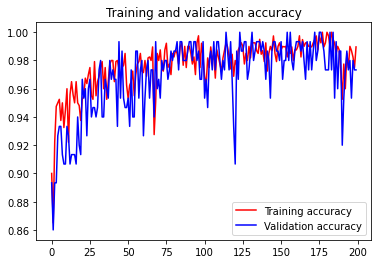

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# **Upload & Test**

In [ ]:
def getcode(n) : 
  if n < 0.5 :
    return 'COVID-19'
  if n > 0.5 :
    return 'NORMAL'

Saving Capture.PNG to Capture.PNG
Saving sssss.PNG to sssss.PNG
Capture.PNG      

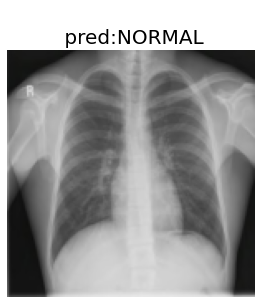

sssss.PNG      

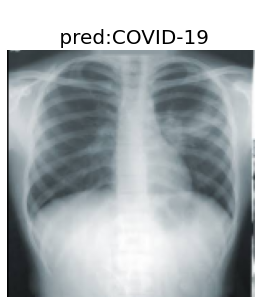

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys(): 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=1)

  path = '/content/' + fn
  img = plt.imread(path)
  img = resize(img, (150,150))

  print(fn,end = '      ')
  plt.figure(num=10,figsize=(10,10)) 
  plt.subplot(221)
  plt.imshow(img)
  plt.axis('off')
  plt.gray()
  plt.title( " \n pred:"+ getcode((classes[0][0])), fontsize=20)
  plt.show()



# **test all uploaded images** 

 
 

1-s2.0-S1930043320301370-gr2 (1).jpg      

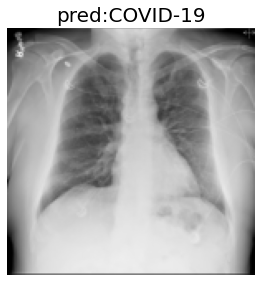

 

1-s2.0-S1930043320301370-gr2 (3).jpg      

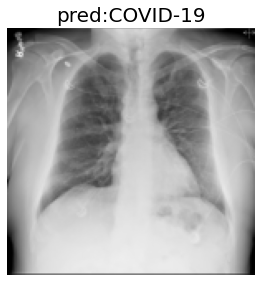


1-s2.0-S1930043320301370-gr2 (5).jpg      

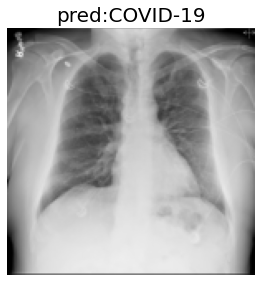


NORMAL (15).jpeg      

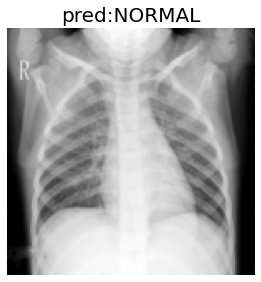

 

1-s2.0-S1930043320301370-gr2.jpg      

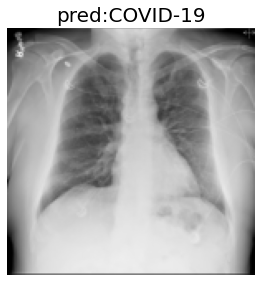


COVID-19 (2).jpg      

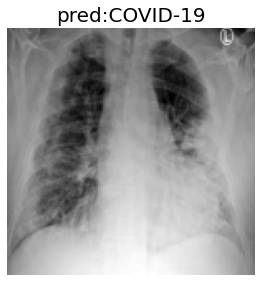


NORMAL (16).jpeg      

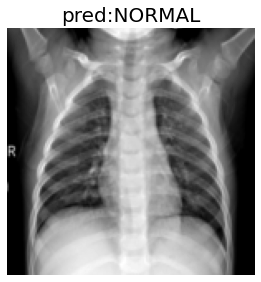


NORMAL (17).jpeg      

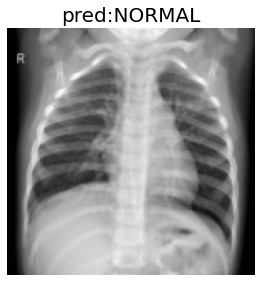


COVID-19 (1).jpeg      

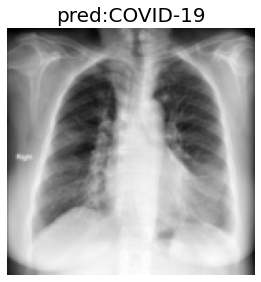


NORMAL (12).jpeg      

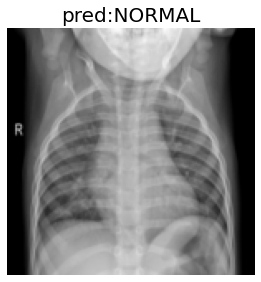


1-s2.0-S1930043320301370-gr2 (4).jpg      

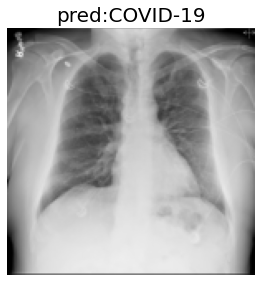


102393223_178987783550967_4229411409883674823_n.jpg      

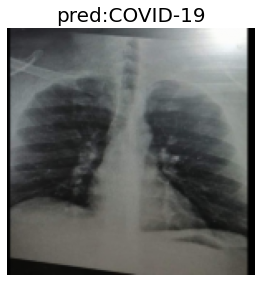


102393223_178987783550967_4229411409883674823_n (1).jpg      

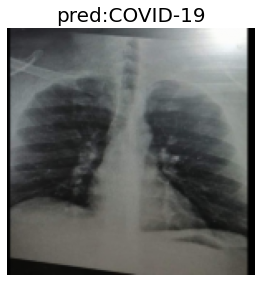


NORMAL (11).jpeg      

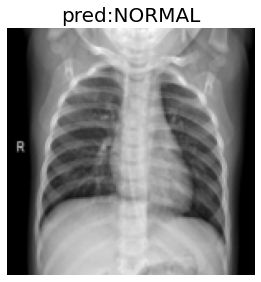

 

NORMAL (14).jpeg      

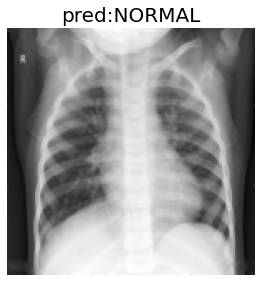


COVID-19 (4).png      

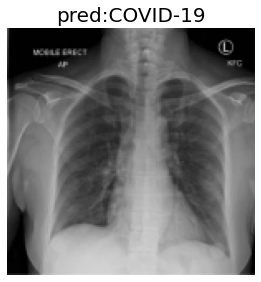


NORMAL (18).jpeg      

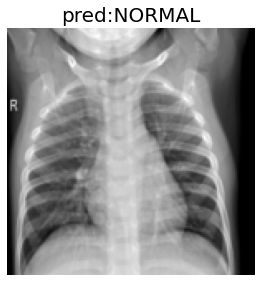


COVID-19 (1) (1).png      

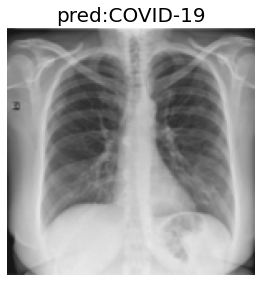


NORMAL (13).jpeg      

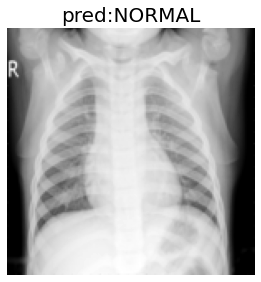


COVID-19 (1).jpg      

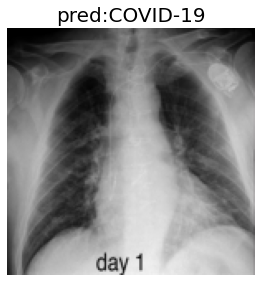


83038714_251259636090123_3908868737024917504_n.jpg      

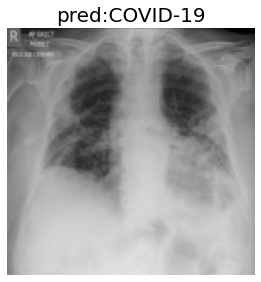


COVID-19 (2).png      

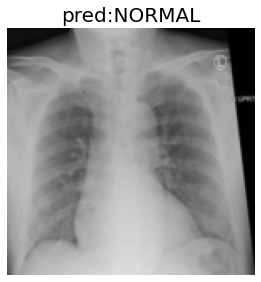


COVID-19 (2).jpeg      

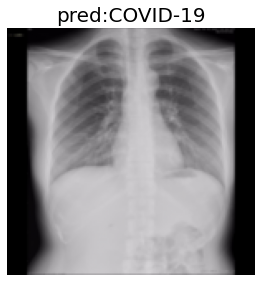


1-s2.0-S1930043320301370-gr2 (2).jpg      

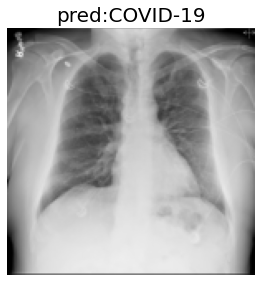

In [ ]:
img_Bdir='/content/'
dirs=os.listdir('/content')
for fn in dirs:
  try:
    path = img_Bdir + fn
    img = image.load_img(path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])


    classes = model.predict(images, batch_size=1)
    print('\n'+fn,end = '      ')

    path = '/content/' + fn
    img = plt.imread(path)
    img = resize(img, (150,150))

    plt.figure(figsize=(10,10)) 
    plt.subplot(222)
    plt.imshow(img)
    plt.axis('off')
    plt.gray()
    plt.title( "pred:"+ getcode((classes[0][0])), fontsize=20)
    plt.show()

  except:
    print(" ")

# **Print the VALIDATION DATA**

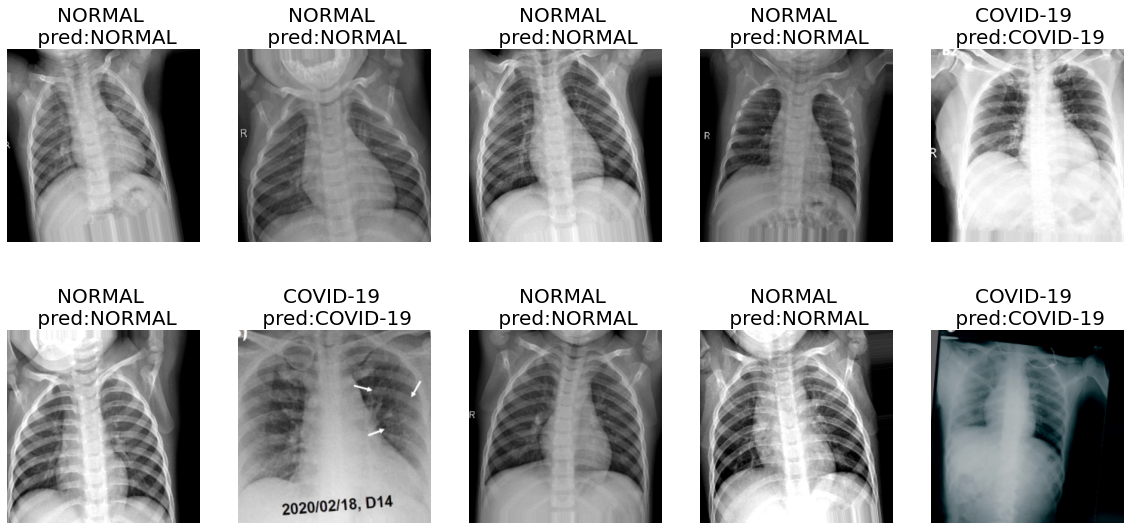

In [ ]:
i=0
x,y=val_generator.next()
classes = model.predict(x)


plt.figure(figsize=(20,25))
for img in x:
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.gray()
  plt.title( getcode(y[i])+" \n pred:"+ getcode((classes[i])), fontsize=20)
  i=i+1
plt.show()

